In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
from google.colab import drive
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
!python3 -m spacy download en_core_web_sm

In [ ]:
#установим ширину колонки
pd.set_option('max_colwidth', 500)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [ ]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

In [ ]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"therein someone made we an off myself you 've during six much because already am anywhere although everywhere just bottom only almost them might wherein five neither otherwise when call after are since would nothing move various wherever sometime eight nor ours whose ’s nevertheless part perhaps that some nine amongst many i yourselves least hereupon whereafter ten whether as does between me ‘d most other through unless herself than everyone have about where thereby whom every yet he few everything another ever 'm ‘ve ourselves its becomes once seem something against done across hundred moreover above being make meanwhile empty this by fifty more really show beforehand be please while hereafter onto what however somehow whither behind always side on often themselves 're anyway these along regarding ’d give her mostly whereupon must say again anyhow they in thru itself serious those fifteen own name formerly amount among their whence same therefore whoever sometimes indeed ‘m go else t

In [ ]:
data['cleaned_text'] = data['text'].apply(
    lambda x: "".join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(10)

,label,text,cleaned_text
4989,1,Phony å£350 award - Todays Voda numbers ending XXXX are selected to receive a å£350 award. If you have a match please call 08712300220 quoting claim code 3100 standard rates app,phonyå£350awardtodaysvodanumberendxxxxselectreceiveå£350awardmatchquoteclaimcodestandardrateapp
3476,0,I got it before the new year cos yetunde said she wanted to surprise you with it but when i didnt see money i returned it mid january before the &lt;#&gt; day return period ended.,getnewyearcosyetundesaywantsurprisenotmoneyreturnmidjanuarylt;#&gtdayreturnperiodend
577,0,ÌÏ wait 4 me in sch i finish ard 5..,ìïwaitschfinishard
2529,0,Can you just come in for a sec? There's somebody here I want you to see,comesecsomebodywant
1286,0,"Night has ended for another day, morning has come in a special way. May you smile like the sunny rays and leaves your worries at the blue blue bay. Gud mrng",nightenddaymorningcomespecialwaysmilelikesunnyrayleaveworrybluebluebaygudmrng
5029,0,Is there coming friday is leave for pongal?do you get any news from your work place.,comefridayleavepongal?donewsworkplace
2952,1,"URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact U! Call 08714714011","urgentmobileawardå£1,500bonuscallerprize27/6/03finalattemptcontactu"
3742,0,"Nah, Wednesday. When should I bring the mini cheetos bag over?",nahwednesdaybringminicheetobag
3374,0,:),
572,0,Can you open the door?,opendoor


In [ ]:
data['cleaned_text'].iloc[4]

'nahthinkgousflive'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

In [ ]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'therein someone made we an off myself you sincere during six much because already am anywhere although everywhere only bottom almost them un might wherein five neither detail otherwise when call after are since would nothing move wherever sometime eight nor de ours whose nevertheless part perhaps that some nine interest amongst many i system yourselves least hereupon whereafter ten whether as between me most other through herself than couldnt everyone have about where thereby whom every he yet few everything another ever cry ourselves its becomes once seem something against done across hundred moreover above being meanwhile empty this by fifty more show beforehand be please while hereafter onto what however somehow whither behind always side on fill often themselves anyway these along give her mostly whereupon must again anyhow they in ltd thru itself serious those fifteen own name formerly cant amount among their whence same therefore whoever sometimes indeed go else thin thus but no

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [ ]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
logreg_pred = logreg.predict(X_test_vectorized)
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1207
           1       0.83      0.10      0.18       186

    accuracy                           0.88      1393
   macro avg       0.85      0.55      0.56      1393
weighted avg       0.87      0.88      0.83      1393



In [ ]:
dftree = DecisionTreeClassifier().fit(X_train_vectorized, y_train)
dftree_pred = dftree.predict(X_test_vectorized)
print(classification_report(y_test, dftree_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1207
           1       0.83      0.10      0.18       186

    accuracy                           0.88      1393
   macro avg       0.85      0.55      0.56      1393
weighted avg       0.87      0.88      0.83      1393



In [ ]:
nb = MultinomialNB().fit(X_train_vectorized, y_train)
nb_pred = nb.predict(X_test_vectorized)
print(classification_report(y_test, nb_pred ))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       1.00      0.07      0.13       186

    accuracy                           0.88      1393
   macro avg       0.94      0.53      0.53      1393
weighted avg       0.89      0.88      0.83      1393



In [ ]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [ ]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize,
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_vectorized

<4179x2 sparse matrix of type '<class 'numpy.int64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(X_train_vectorized.toarray(), columns=custom_vectorizer.get_feature_names_out()).head()

,ok,sorrylater
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
logreg_pred = logreg.predict(X_test_vectorized)
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1207
           1       0.93      0.14      0.24       186

    accuracy                           0.88      1393
   macro avg       0.91      0.57      0.59      1393
weighted avg       0.89      0.88      0.84      1393



In [ ]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1207
           1       0.93      0.14      0.24       186

    accuracy                           0.88      1393
   macro avg       0.91      0.57      0.59      1393
weighted avg       0.89      0.88      0.84      1393



In [ ]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [ ]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=2,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 8
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 8
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1760 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dis

----------
iter: 1
n_candidates: 534
n_resources: 24
Fitting 2 folds for each of 534 candidates, totalling 1068 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.78787879 0.78787879 0.78787879]
  warnings.warn(


----------
iter: 2
n_candidates: 178
n_resources: 72
Fitting 2 folds for each of 178 candidates, totalling 356 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84563492 0.84563492 0.84563492]
  warnings.warn(


----------
iter: 3
n_candidates: 60
n_resources: 216
Fitting 2 folds for each of 60 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.84185704 0.84185704 0.84185704]
  warnings.warn(


----------
iter: 4
n_candidates: 20
n_resources: 648
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.85938157]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.85628559 0.85628559 0.86091522]
  warnings.warn(


----------
iter: 5
n_candidates: 7
n_resources: 1944
Fitting 2 folds for each of 7 candidates, totalling 14 fits
CPU times: user 7.94 s, sys: 320 ms, total: 8.26 s
Wall time: 43.9 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.87288093]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86310303 0.86310303 0.87802603]
  warnings.warn(


HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

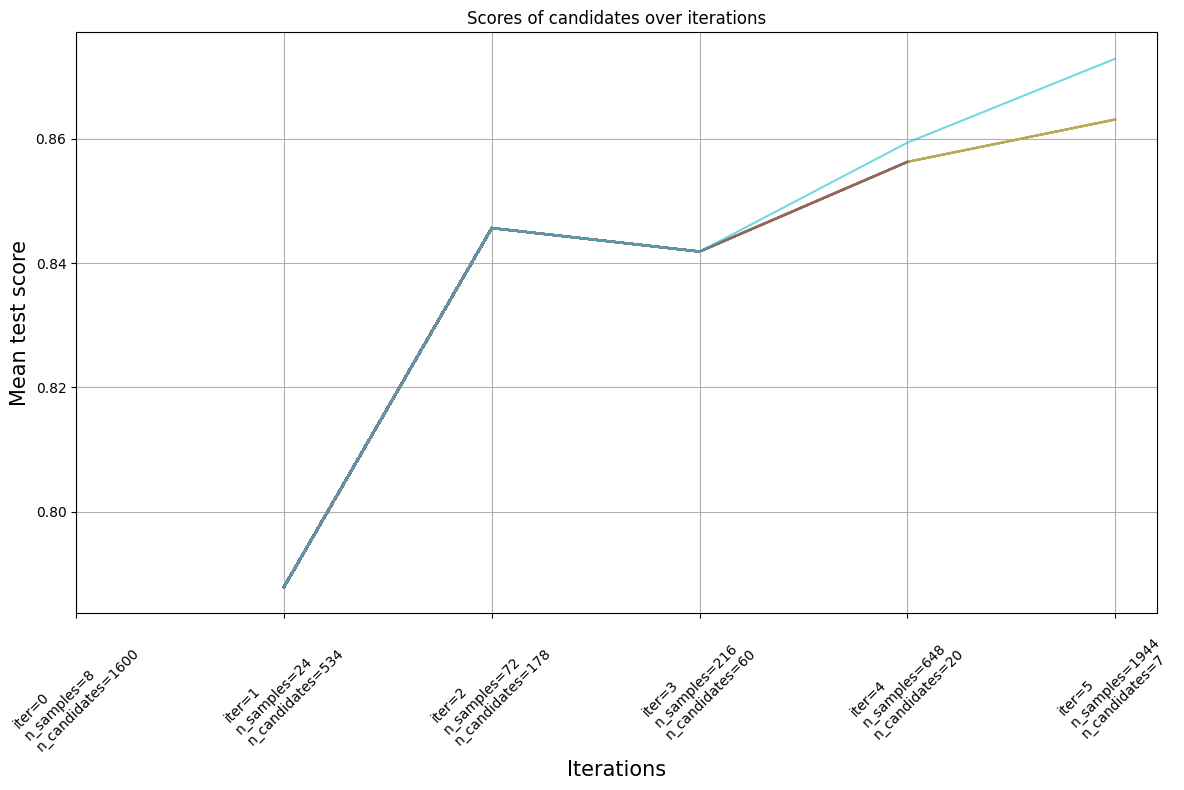

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
grid_search.best_score_

0.8728809339148051

In [ ]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       1.00      0.06      0.11       186

    accuracy                           0.87      1393
   macro avg       0.94      0.53      0.52      1393
weighted avg       0.89      0.87      0.82      1393



In [ ]:
accurace_logreg = accuracy_score(y_test,logreg_pred)
print(accurace_logreg)

0.87724335965542


In [ ]:
accurace_dftree = accuracy_score(y_test,dftree_pred)
print(accurace_dftree)

0.87724335965542


In [ ]:
accurace_dftree = accuracy_score(y_test , nb_pred)
print(accurace_dftree)

0.8758076094759512


In [ ]:
!pip install eli5

In [ ]:
import eli5

In [ ]:
grid_search.best_estimator_['clf']

LogisticRegression()

In [ ]:
eli5.show_weights(
    estimator=grid_search.best_estimator_['clf'],
    feature_names= list(grid_search.best_estimator_['counter'].get_feature_names_out()),
    top=(50, 5)
)

Weight?,Feature
+3.935,co
-0.998,lt
-1.095,sorrylater
-1.416,gt
-1.902,<BIAS>
